In [12]:
from tensorflow.keras.models import load_model

# Chargement du modèle
model2 = load_model('mobilenetv2_best.keras')

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing import image
import cv2

# Génération des images et entraînement du modèle

In [19]:
# Paramètres
batch_size = 32
image_size = (224, 224)  # Ajustez la taille au besoin

# Créer un générateur de données avec augmentation des données et mise à l'échelle
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range     = 20,
    width_shift_range  = 0.2,
    height_shift_range = 0.2,
    shear_range        = 0.2,
    horizontal_flip    = True,
    fill_mode          = 'nearest'
)

# Créer des générateurs de données distincts pour les ensembles d'entraînement, de validation et de test
train_generator = datagen.flow_from_directory(
    directory   = 'PBC_APL_train',
    target_size = image_size,
    batch_size  = batch_size,
    class_mode  = 'categorical',
)

validation_generator = datagen.flow_from_directory(
    directory   = 'PBC_APL_val',
    target_size = image_size,
    batch_size  = batch_size,
    class_mode  = 'categorical',
)

test_generator = datagen.flow_from_directory(
    directory   = 'PBC_APL_test',
    target_size = image_size,
    batch_size  = batch_size,
    class_mode  = 'sparse',
    shuffle      = False,
)

Found 18302 images belonging to 9 classes.
Found 5490 images belonging to 9 classes.
Found 2354 images belonging to 9 classes.


In [3]:
unfreeze_from_layer = "Conv_1"  # Adjust the layer name based on your model architecture

# Charger le modèle de base MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    if layer.name == unfreeze_from_layer:
        break
    layer.trainable = False
    

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(9, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input,outputs)
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Entraîner le modèle
num_epochs = 7
history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator
)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

# Affichage de l'accuracy, rapport de classification et matrice de confusion

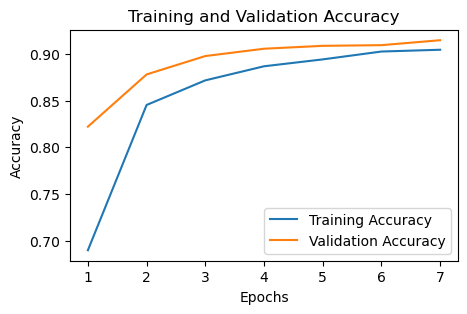

In [22]:
import matplotlib.pyplot as plt

# Supposons que vous ayez un objet history provenant de l'entraînement de votre modèle
# history = model.fit(...)

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Tracer les courbes d'accuracy et val_accuracy
epochs = range(1, len(accuracy) + 1)
plt.figure(figsize=(5, 3))
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [20]:
predictions_test = model2.predict(test_generator, steps=len(test_generator), verbose=1)

74/74 [==============================] - 134s 2s/step


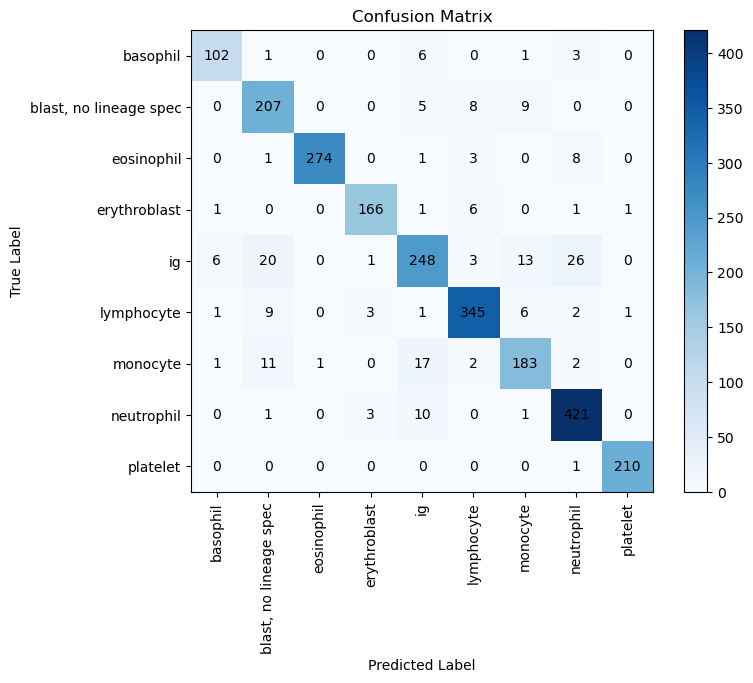

In [21]:

# Prédire les classes pour l'ensemble de validation
y_pred_test = np.argmax(predictions_test, axis=1)

# Obtenir les vraies classes
y_true_test = test_generator.classes

# Obtenez les noms des classes dans l'ordre
class_names = list(test_generator.class_indices.keys())

# Calculer la matrice de confusion
confusion_mtx = confusion_matrix(y_true_test, y_pred_test)

# Afficher la matrice de confusion avec Matplotlib imshow
plt.figure(figsize=(8, 6))
plt.imshow(confusion_mtx, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

# Définir les étiquettes des axes avec rotation à 45 degrés
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Ajouter les valeurs dans les cellules
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(confusion_mtx[i, j]), ha='center', va='center')

# Faire pivoter les étiquettes du bas à 90 degrés
plt.xticks(rotation=90)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [22]:

print("Classification Report:")
print(classification_report(y_true_test, y_pred_test, target_names=class_names))

Classification Report:
                        precision    recall  f1-score   support

              basophil       0.92      0.90      0.91       113
blast, no lineage spec       0.83      0.90      0.86       229
            eosinophil       1.00      0.95      0.98       287
          erythroblast       0.96      0.94      0.95       176
                    ig       0.86      0.78      0.82       317
            lymphocyte       0.94      0.94      0.94       368
              monocyte       0.86      0.84      0.85       217
            neutrophil       0.91      0.97      0.94       436
              platelet       0.99      1.00      0.99       211

              accuracy                           0.92      2354
             macro avg       0.92      0.91      0.92      2354
          weighted avg       0.92      0.92      0.92      2354



# Afficher aléatoirement des images bien prédites et leur grad-cam

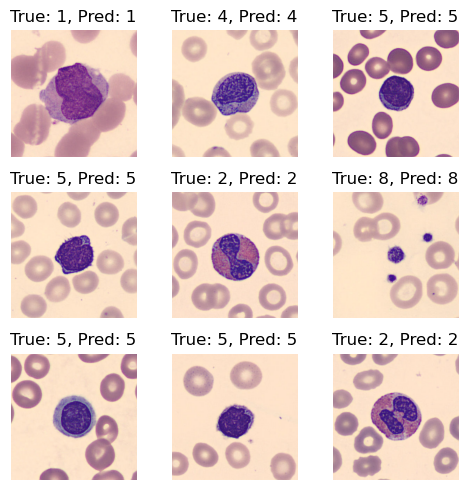

In [23]:
# Get indices of correctly predicted samples
correct_indices = np.where(y_pred_test == y_true_test)[0]

# Randomly select 9 correct samples
random_correct_indices = np.random.choice(correct_indices, 9, replace=False)

# Display the images
plt.figure(figsize=(5,5))
for i, idx in enumerate(random_correct_indices):
    img_path = test_generator.filepaths[idx]
    img = plt.imread(img_path)
    
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"True: {y_true_test[idx]}, Pred: {y_pred_test[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [24]:
# Function to apply Guided Grad-CAM on a specific image
def apply_guided_grad_cam(model, img_path, layer_name, target_size):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Create the gradient model
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    # Use GradientTape to compute gradients
    with tf.GradientTape() as tape:
        inputs = tf.cast(img_array, tf.float32)
        conv_outputs, predictions = grad_model(inputs)
        loss = predictions[:, 0]

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)

    # Compute guided gradients
    cast_conv_outputs = tf.cast(conv_outputs > 0, "float32")
    cast_grads = tf.cast(grads > 0, "float32")
    guided_grads = cast_conv_outputs * cast_grads * grads

    # Remove batch dimension
    conv_outputs = conv_outputs[0]
    guided_grads = guided_grads[0]

    # Compute weights
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    # Compute CAM
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1)

    # Grab spatial dimensions of the input image and resize the CAM
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))

    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max()

    return heatmap

# Choose the layer for Guided Grad-CAM
guided_grad_cam_layer = "out_relu"  # You may need to adjust this based on your model architecture

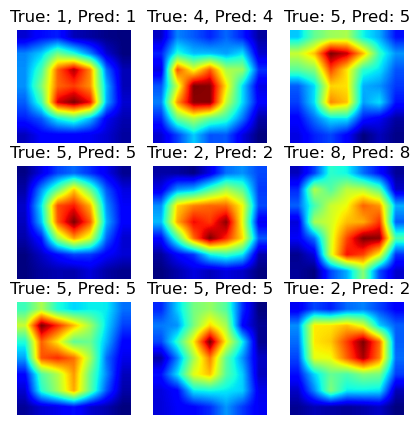

In [25]:
# Display the Guided Grad-CAM for each image
plt.figure(figsize=(5,5))
for i in range(9):
    batch_index = random_correct_indices[i] // batch_size
    image_index_in_batch = random_correct_indices[i] % batch_size
    img_path = test_generator.filepaths[batch_index * batch_size + image_index_in_batch]

    guided_grad_cam_result = apply_guided_grad_cam(model2, img_path, guided_grad_cam_layer, image_size)

    plt.subplot(3, 3, i + 1)
    plt.imshow(guided_grad_cam_result, cmap='jet')
    plt.title(f"True: {y_true_test[random_correct_indices[i]]}, Pred: {y_pred_test[random_correct_indices[i]]}")
    plt.axis('off')

plt.show()

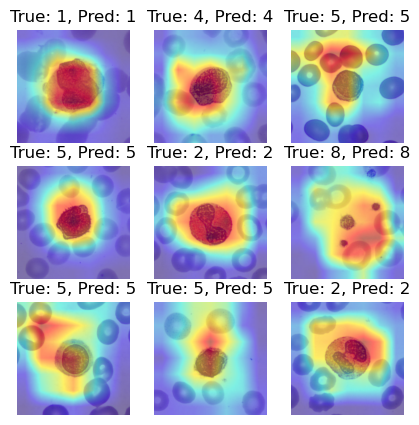

In [26]:
# Display the Guided Grad-CAM for each image along with the original image
plt.figure(figsize=(5,5))
for i in range(9):
    batch_index = random_correct_indices[i] // batch_size
    image_index_in_batch = random_correct_indices[i] % batch_size
    img_path = test_generator.filepaths[batch_index * batch_size + image_index_in_batch]

    # Load the original image
    original_img = cv2.imread(img_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    # Apply Guided Grad-CAM
    guided_grad_cam_result = apply_guided_grad_cam(model2, img_path, guided_grad_cam_layer, image_size)

    # Resize the heatmap to match the original image size
    heatmap = cv2.resize(guided_grad_cam_result, (original_img.shape[1], original_img.shape[0]))

    # Normalize the heatmap
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap_rgb = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(original_img, 0.5, heatmap_rgb, 0.5, 0)

    plt.subplot(3, 3, i + 1)
    plt.imshow(superimposed_img)
    plt.title(f"True: {y_true_test[random_correct_indices[i]]}, Pred: {y_pred_test[random_correct_indices[i]]}")
    plt.axis('off')

plt.show()


# Afficher la grad-cam d'une image solo et faire sa prédiction

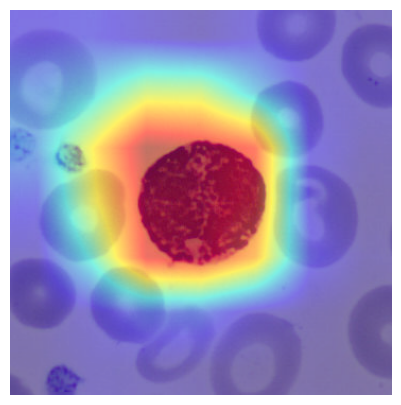

In [17]:
# Display the Guided Grad-CAM for each image along with the original image
plt.figure(figsize=(5,5))
original_img = cv2.imread('PBC_dataset_normal_DIB/basophil/BA_47.jpg')
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Apply Guided Grad-CAM
guided_grad_cam_result = apply_guided_grad_cam(model2, img_path, guided_grad_cam_layer, (224,224))

# Resize the heatmap to match the original image size
heatmap = cv2.resize(guided_grad_cam_result, (original_img.shape[1], original_img.shape[0]))

# Normalize the heatmap
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
heatmap_rgb = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# Superimpose the heatmap on the original image
superimposed_img = cv2.addWeighted(original_img, 0.5, heatmap_rgb, 0.5, 0)

plt.imshow(superimposed_img)
plt.axis('off')

plt.show()


1/1 [==============================] - 2s 2s/step
Classe prédite: basophil


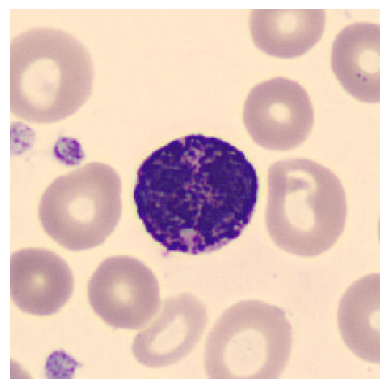

In [18]:

# Charger l'image
img_path = 'PBC_dataset_normal_DIB/basophil/BA_47.jpg'
img = image.load_img(img_path, target_size=(224, 224))

# Convertir l'image en tableau numpy
img_array = image.img_to_array(img)

# Ajouter une dimension supplémentaire (batch_size) car le modèle prend généralement des lots d'images
img_array = np.expand_dims(img_array, axis=0)

# Prétraiter l'image pour la faire correspondre au format que le modèle attend
img_array = preprocess_input(img_array)

# Faire une prédiction
predictions = model2.predict(img_array)

# Obtenir l'indice de la classe prédite
predicted_class_index = np.argmax(predictions)

class_indices = {'basophil': 0, 'blast, no lineage spec': 1,  'eosinophil' : 2, 'erythroblast': 3, 'ig' : 4, 
                 'lymphocyte' : 5, 'monocyte' : 6, 'neutrophil' : 7, 'platelet' : 8}

# Obtenir le nom de la classe prédite
predicted_class_name = list(class_indices.keys())[list(class_indices.values()).index(predicted_class_index)]

# Afficher la classe prédite
print("Classe prédite:", predicted_class_name)

# Afficher l'image
plt.imshow(img)
plt.axis('off')
plt.show()


# Afficher des images aléatoires mal prédites et leur grad-cam

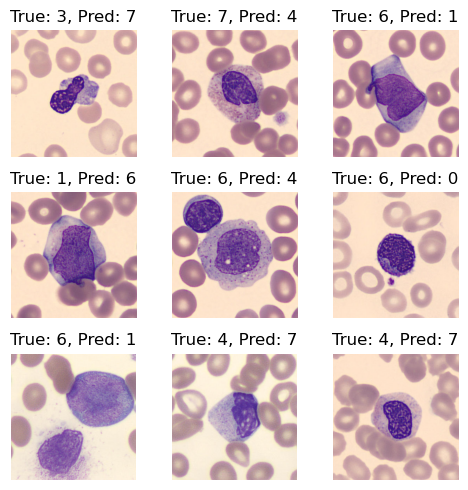

In [27]:
# Get indices of correctly predicted samples
incorrect_indices = np.where(y_pred_test != y_true_test)[0]

# Randomly select 9 correct samples
random_incorrect_indices = np.random.choice(incorrect_indices, 9, replace=False)

# Display the images
plt.figure(figsize=(5,5))
for i, idx in enumerate(random_incorrect_indices):
    img_path = test_generator.filepaths[idx]
    img = plt.imread(img_path)
    
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"True: {y_true_test[idx]}, Pred: {y_pred_test[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


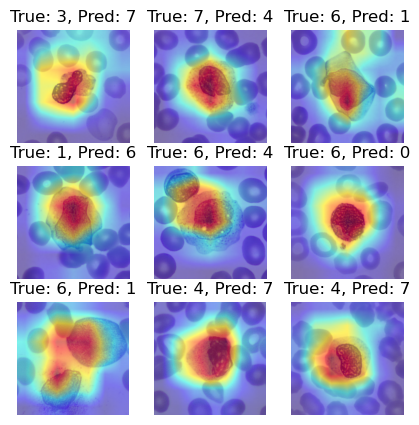

In [28]:
# Display the Guided Grad-CAM for each image along with the original image
plt.figure(figsize=(5,5))
for i in range(9):
    batch_index = random_incorrect_indices[i] // batch_size
    image_index_in_batch = random_incorrect_indices[i] % batch_size
    img_path = test_generator.filepaths[batch_index * batch_size + image_index_in_batch]

    # Load the original image
    original_img = cv2.imread(img_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    # Apply Guided Grad-CAM
    guided_grad_cam_result = apply_guided_grad_cam(model2, img_path, guided_grad_cam_layer, image_size)

    # Resize the heatmap to match the original image size
    heatmap = cv2.resize(guided_grad_cam_result, (original_img.shape[1], original_img.shape[0]))

    # Normalize the heatmap
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap_rgb = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(original_img, 0.5, heatmap_rgb, 0.5, 0)

    plt.subplot(3, 3, i + 1)
    plt.imshow(superimposed_img)
    plt.title(f"True: {y_true_test[random_incorrect_indices[i]]}, Pred: {y_pred_test[random_incorrect_indices[i]]}")
    plt.axis('off')

plt.show()
